## Priors for GP hyperparameters are important (and tricky)

In the last lesson, we looked at samples drawn from a GP prior with the exponentiated quadratic kernel (`ExpQuad`) with varying scale $\eta$ and lengthscale $\ell$.  We then modeled some hypothetical hospital call data where we assumed we knew both the scale and lengthscale.  In reality we won't know either of these parameters.  And, they're not necessarily nuisance parameters that we need to deal with but can largely ignore the results of.  We can learn a lot about the data from the posterior distributions of $\eta$ and $\ell$.  As is true for all of Bayesian statistics, our results depend on both our prior and on the data.  For GPs, the dependence on the prior can be very strong, so it's important to know what we're doing here.

We'll make a small data set we can use to illustrate the main points of this section.  Our goal will be to forecast the underlying function as far into the future as we can.  You could imagine this data is revenue of a small company.  We'll assume Gaussian noise for the likelihood.  Also notice that the data is offset from zero, so we'll need to include an intercept term in the model to properly account for this.  

In [1]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt

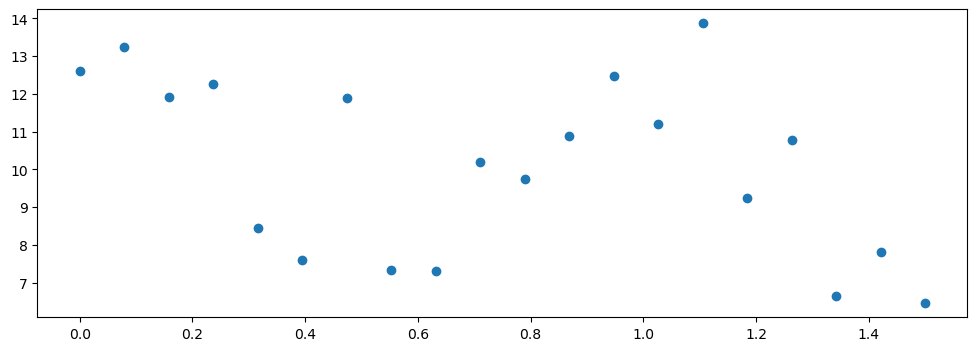

In [2]:
# first set random seed so data is reproducable
RANDOM_SEED = 987654321
rng = np.random.default_rng(RANDOM_SEED)

N = 20
x = np.linspace(0, 1.5, N)
f_true = 2.0 * np.sin(2 * np.pi * 1 * x + 0.5*np.pi)
#f_true = np.zeros(N)
intercept_true = 10

sigma_true = 1.6
y = intercept_true + f_true + sigma_true * rng.normal(size=N)

plt.figure(figsize=(12, 4))
plt.plot(x, y, 'o');

We generated the data using the sine function, so we know it's not a GP to begin with.  That's OK, we can still use a GP to try and capture it's variance.  The data is a little ambiguous on purpose.  If you didn't know there was a sine function underlying it, would you be able to guess that from just looking?  Maybe, but maybe it also just looks like random noise.  The human brain is very good at finding patterns though, even if there aren't any.  

The model code below should look nearly identical to what we were doing in the previous lesson but with a few small differences:
- We need to set priors on `eta` and `ell` (that's the point of this lesson!)
- The likelihood is normal instead of Poisson, so we don't exponentiate the GP `f` to make it positive anymore and we need to set a prior on the noise variance `sigma`
- We include a prior for the intercept term, which we call `beta0`.

Now about those priors.  We're going to start with a naive choice of priors and then gradually build our intuition.  We'll cut to the chase and say now that there is no "one perfect prior" that you'll use for all your GP problems, or Bayesian problems in general.  You'll need strategies to choose priors and to know what to watch out for.  That's what this lesson is about.

First of all, it's clear that both `eta` and `ell` are positive values that range from zero to infinity.  We also know from the last lesson that the scale `eta` is basically a standard deviation.  For `eta`, it's reasonable to start with the same prior we use for `sigma`: a `pm.HalfNormal` prior with a relatively large `sigma` value.  We know that the true value of `eta` will be in the high mass region of the prior.  We'll choose the same priors for `eta` and `sigma` here so we don't bias the model either way towards explaining the data with the GP or with calling it all noise.

The lengthscale `ell` is going to be trickier.  All we know is that it's positive, so let's use a Uniform prior that's bounded between zero and five.  You could try a `HalfFlat` which has no upper bound, but you'll have some serious difficulties sampling.  You'll understand why by the end of this lesson.

Let's fit the model and then look at the sample paths of the posterior.

In [6]:
with pm.Model() as model:
    eta = pm.HalfNormal("eta", sigma=5)
    ell = pm.Uniform("ell", lower=0, upper=5)
    
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    K = cov_func(x[:, None])
    
    L = pt.slinalg.cholesky(K + 1e-6 * pt.eye(N))
    v = pm.Normal("v", mu=0.0, sigma=1.0, size=N)
    f = pm.Deterministic("f", L @ v)
   
    beta0 = pm.Normal("beta0", mu=np.mean(y), sigma=5)
    mu = pm.Deterministic("mu", beta0 + f)
    
    sigma = pm.HalfNormal("sigma", sigma=5.0)
    y_ = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    idata = pm.sample(target_accept=0.97, nuts_sampler="numpyro")

/Users/andre/development/pymc/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.505527
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:24.124385
Transforming variables...
Transformation time =  0:00:00.687263


In [7]:
idata.sample_stats.diverging.sum()

<xarray.DataArray 'diverging' ()>
array(0)

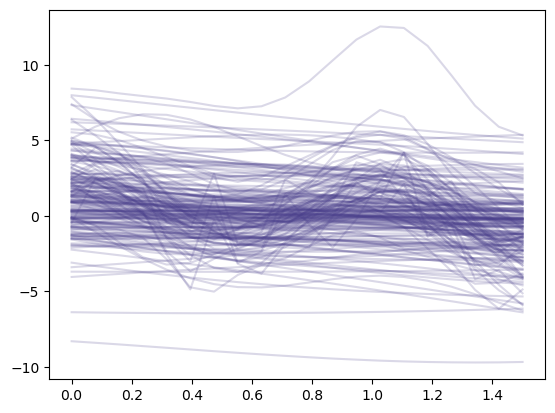

In [8]:
ix = np.random.randint(0, 4000, 200)
f_s = az.extract(idata.posterior, var_names="f").isel(sample=ix).data

plt.plot(x, f_s, color="darkslateblue", alpha=0.2);

If you look closely, there are 3 different "modes" here, or three different types of lines in the posterior. 

1. Very jagged.  These are the ones that look similar to drawing straight lines between the data points connect-the-dots style.
2. Smooth sine type waves (!).  These are trying to represent the underlying sine function that we're looking for.
3. Flatish lines, that look like the results of an intercept-only model. 

If you have some experience doing Bayesian modeling, you'll recognize immediately that this is a pretty strong clue that the posterior has a difficult geometry that may cause the sampler problems.

This behavior mostly comes from three types of lengthscale in the posterior:

1. Very small lengthscale
2. Medium lengthscale
3. Large lengthscale

Below is a histogram of the lengthscale posterior samples where I've labeled the three regions.  I'm not using Arviz so I can have more control over how the samples are binned and so there's no smoothing added. 

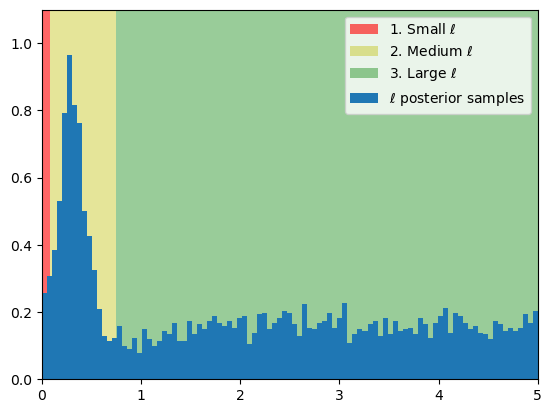

In [9]:
ell = az.extract(idata.posterior, var_names="ell")

data_res = np.diff(x)[0]  # smallest spacing between x values
data_int = 0.75           # where it looks like the posterior peak ends

plt.fill_between([0, data_res], [1.5, 1.5], color="r", alpha=0.6, edgecolor=None, label="1. Small $\ell$");
plt.fill_between([data_res, data_int], [1.5, 1.5], color="y", alpha=0.4, edgecolor=None, label="2. Medium $\ell$");
plt.fill_between([data_int, 5], [1.5, 1.5], color="green", alpha=0.4, edgecolor=None, label="3. Large $\ell$");

plt.hist(ell.data, bins=np.linspace(0, 5, 100), density=True, label="$\ell$ posterior samples");
plt.xlim([0, 5]);
plt.ylim([0, 1.1]);

plt.legend();

Region 1 is labeled the way it is because it's the range from $\ell = 0$ up to the minimum spacing between the $x$-points.  Region two goes from there up until 0.75, which is just where I think the peak in the posterior ends.  Region 3 is from there on up to the boundary given by our prior at 5.  These really aren't hard boundaries though.  Lengthscales describe roughly how quickly the function changes, which is a sort of "soft" definition itself anyways.  

Before explaining why I choose the regions this way, let's verify how good my labeling is.  Let's select the posterior GP path samples by their lengthscale.

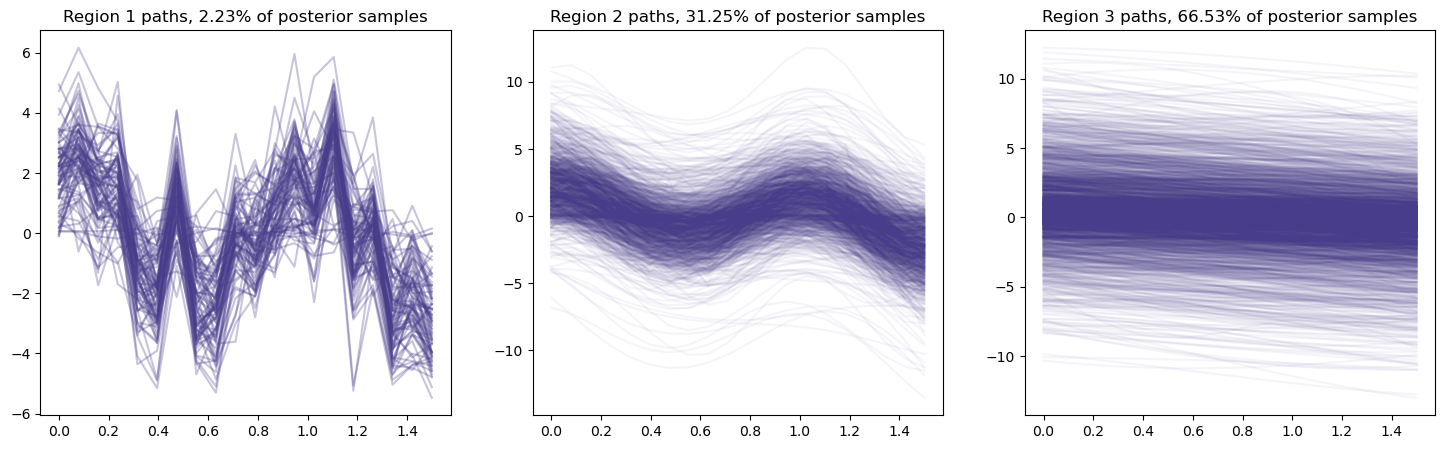

In [10]:
f_s = az.extract(idata.posterior, var_names="f").data

r1_ix = np.where(ell.data < data_res)[0]
r2_ix = np.where((data_res < ell.data) & (ell < 0.75))[0]
r3_ix = np.where(ell > 0.75)[0]

fig, axs = plt.subplots(1, 3, figsize=(18,5)); axs=axs.flatten();

axs[0].plot(x, f_s[:, r1_ix], color="darkslateblue", alpha=0.3);
p = 100 * len(r1_ix) / len(ell.data)
axs[0].set_title("Region 1 paths, %0.2f%% of posterior samples" % p)

axs[1].plot(x, f_s[:, r2_ix], color="darkslateblue", alpha=0.05);
p = 100 * len(r2_ix) / len(ell.data)
axs[1].set_title("Region 2 paths, %0.2f%% of posterior samples" % p)

axs[2].plot(x, f_s[:, r3_ix], color="darkslateblue", alpha=0.05);
p = 100 * len(r3_ix) / len(ell.data)
axs[2].set_title("Region 3 paths, %.2f%% of posterior samples" % p);

Looks pretty good, the categories *mostly* capture the behavior even though you can't really make hard cuts on something like a lengthscale.  Let's talk about each region individually now.  

### Region 1

Region 1 are paths whose lengthscales are less than the resolution of the data.  This is problematic, because if the data resolution is similar to or larger than the lengthscale we start losing the ability to discriminate lengthscales in this region.  The sample paths from the GP prior all look the same - lines that "wiggle" faster than the data does.  This is an example where there is a lack of *identifiability* in the parameter space.  To see exactly why, we can take a look at our covariance matrix here.  Below are two covariance matrices calculated with two different lengthscales.  In the first, the lengthscale is twice the resolution of the $x$-values.  In the second, the lengthscale is half the resolution of the $x$-values.  

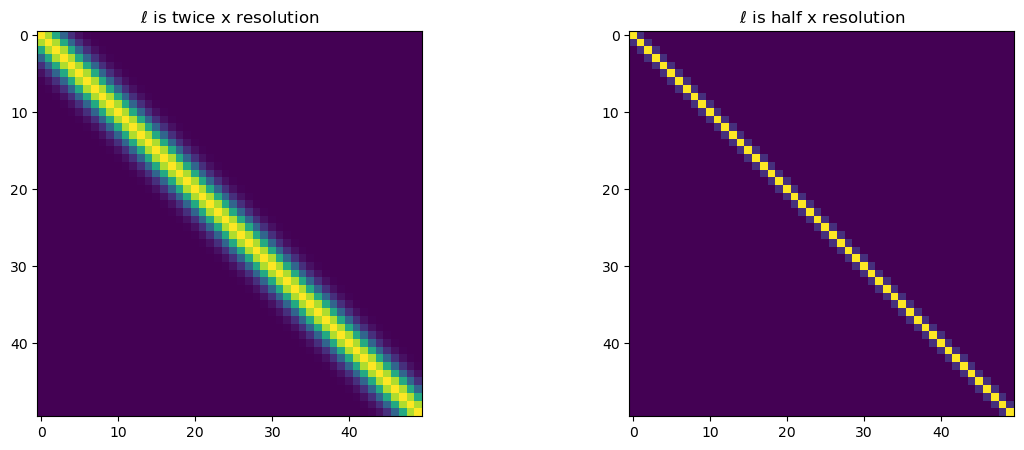

In [11]:
xx = np.arange(50)

K1 = pm.gp.cov.ExpQuad(1, ls=2)(xx[:, None]).eval()
K2 = pm.gp.cov.ExpQuad(1, ls=0.5)(xx[:, None]).eval()

fig, axs = plt.subplots(1, 2, figsize=(14, 5)); axs=axs.flatten();

axs[0].imshow(K1, vmin=0, vmax=1);
axs[0].set_title("$\ell$ is twice x resolution")

axs[1].imshow(K2, vmin=0, vmax=1);
axs[1].set_title("$\ell$ is half x resolution");

#### Aside: white noise

What's happening here is as the lengthscale goes to zero, the exponentiated quadratic kernel is turning into the *white noise kernel*.  It has a particularly simple formula so we'll introduce it here:
$$
k_{\text{white noise}}(x, x') = 
    \begin{cases}
      1 & \text{if } x = x'\\
      0 & \text{otherwise} \,.
    \end{cases}    
$$
The matrix in the right panel above is very nearly this (though you can still make out a fainter blue next to the diagonal).  This is the second kernel function you've met, and we'll see many more in this course.  You'll probably recognize that this is the identity matrix, or the output of `np.eye`.  The white noise kernel is interesting, but it's not terribly useful for modeling in practice.  

What white noise represents is a Gaussian process (and yes, double check the definition, it is technically Gaussian process!) where there is no relationship between $x$ values that has an influence in $y$.  Or, data points are only similar if they are at exactly the same $x$ locations, so $y$ data at $x=1$ is completely independent from $y$ data at $x=2$, or even $x=1.00001$.  Here are two exactly equivalent ways to draw a sample of white noise, the second of which is basically what our `ExpQuad` kernel turned into:

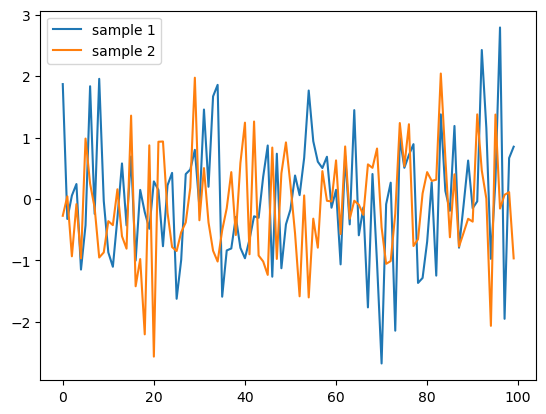

In [12]:
s1 = np.random.randn(100)
s2 = np.random.multivariate_normal(np.zeros(100), np.eye(100), size=1).flatten()

plt.plot(s1, label="sample 1")
plt.plot(s2, label="sample 2")
plt.legend();

You may recall that we covered this in the lesson on multivariate normals.  Here is the same idea but with a bit more sophistication.  In an exercise we'll ask you (with some hints of course) to show that a white noise GP is exactly equivalent to (so a reparameterization of) a hierarchical normal model, or a Gaussian random effect.  

Do you recall the first trick from the last lesson, adding a small diagonal to the covariance to make the Cholesky work?  That's *effectively* the same thing, but conceptually quite different.  Emphasis on *small* diagonal -- this correction should never be apparent in your modeling results.  If you need to add a large diagonal to your covariance matrix to get it to sample without errors, you have another problems in your model that this "fix" is just papering over.  It is possible to hide a faulty model this way, so be careful.  If you actually want to add a Gaussian random effect to your model the white noise kernel is a way to do that -- though you probably should model that random effect directly.  The point is, it's important to distinguish between a numerical correction that's inconsequential to the model, and a specific modeling choice.    

### So what do we do?

We see now that our GP is representing white noise (or IID Gaussian noise) here in region 1.  Remember -- our likelihood is also Gaussian, so we're actually accounting for IID normal noise in the likelihood too.  So there's actually a *second* identifiability issue hitting us in the same place.  The way to fix identifiability issues is by changing the prior.  We should **always** use a prior that restricts us to be *at least* greater than the smallest resolution of the data.  Although there's no "correct" prior, consider this more of a rule than a guideline for GP lengthscale priors.  And quite often, given your prior knowledge on your functions smoothness, you can set a lower bound on the lengthscale prior that's much larger than that.  If you can do that you should.  Before we show precisely how, let's keep moving through the regions where things get a bit simpler.

### Region 2

There's not that much to say about region 2.  This is the sweet spot where the model is picking up the underlying sine function.  Cool.  About 35% of the posterior samples are in this region, so even though the data is pretty ambiguous and noisy, the underlying function is still getting picked up pretty strongly. 

### Region 3

Here things get a little more complicated than region 2.  The posterior paths here are slowly sloped lines, some nearly perfectly flat.  We could probably split region 3 into two regions, slightly sloped lines (lets call this region 3a) and perfectly flat lines (region 3b).  Here the GP is doing two things: modeling a slight decreasing trend in the data (region 3a), and having an identifiability issue with the intercept parameter (region 3b).  

Looking at the data again, region 3a makes sense.  You can see a slight downward trend in the data, even though it's just due to the added noise (the sine function doesn't trend).  It makes sense that the GP posterior is pointing at this, and that it's not certain about it at least (because GPs are great for capturing uncertainty well, and there isn't a downward trend in our data generation process -- it's just from chance).  

Region 3b on the other hand is a bit of a different story.  Large lengthscales all produce flat lines, and when the lengthscale is large enough relative to the $x$ spacing, the covariance matrix just becomes all ones.  Let's meet our third kernel, *the bias kernel* (although I think "intercept kernel" is a better name, because that's what it does).  It's on the other end of the lengthscale spectrum than the white noise kernel. 

It's formula is even simpler than the white noise kernel:
$$
k_{\text{bias}}(x, x') = 1 \,.
$$
It just equals one, always.  It's what you end up with when the lengthscale in the `ExpQuad` kernel becomes large relative to $x$ spacings.  Try it for yourself:

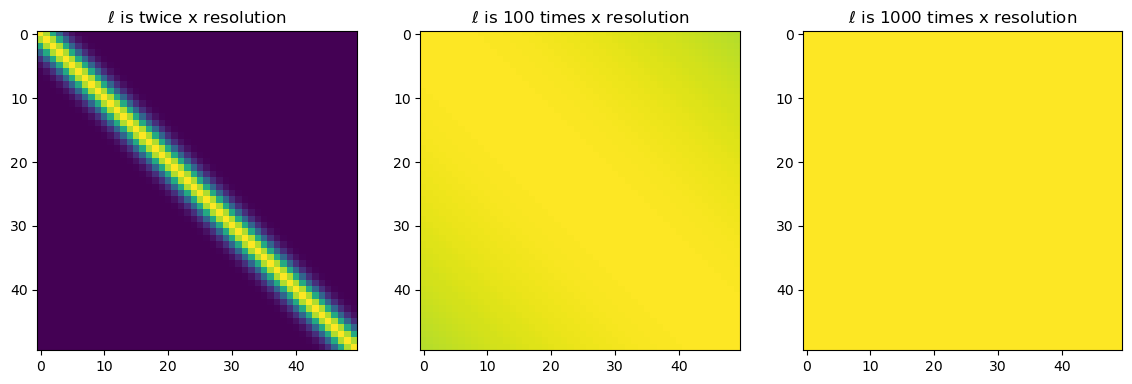

In [13]:
xx = np.arange(50)

K1 = pm.gp.cov.ExpQuad(1, ls=2)(xx[:, None]).eval()
K2 = pm.gp.cov.ExpQuad(1, ls=100)(xx[:, None]).eval()
K3 = pm.gp.cov.ExpQuad(1, ls=1000)(xx[:, None]).eval()

fig, axs = plt.subplots(1, 3, figsize=(14, 5)); axs=axs.flatten();

axs[0].imshow(K1, vmin=0, vmax=1);
axs[0].set_title("$\ell$ is twice x resolution")

axs[1].imshow(K2, vmin=0, vmax=1);
axs[1].set_title("$\ell$ is 100 times x resolution");

axs[2].imshow(K3, vmin=0, vmax=1);
axs[2].set_title("$\ell$ is 1000 times x resolution");

There's really no difference between $\ell = 100$ and $\ell = 1000$ in the example above.  When you're setting priors on the lengthscale, keep this in mind.  

**Exercise:** Try running the above model with a `HalfFlat` prior instead of the `Uniform` between zero and five.  It has a really hard time sampling because nearly *all* of your prior mass is on just adding another intercept term, region 3b.  Only an infinitesimally small amount is actually in the relevant region of the parameter space. 


Now we'll draw GP prior samples using the bias kernel, to convince you that it's actually a real covariance matrix.  To help your intuition, it's saying that no matter how far apart you are in $x$, all $y$ values are equally related.  These equally strong correlations everywhere are why you see flat lines.

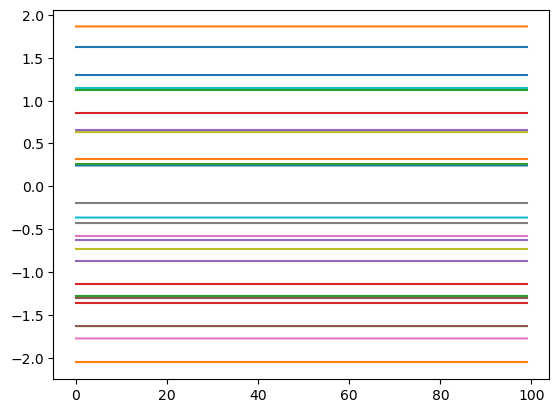

In [14]:
s = np.random.multivariate_normal(np.zeros(100), np.ones((100, 100)), size=25)
plt.plot(s.T, label="draws from GP with bias kernel");

This is exactly the same sorts of lines you would get if instead of a GP, you used an intercept only model.

Now let's ask where we've allocated prior mass.  Our prior was uniform between zero and 5.  Relative to these regions, about

- 1.58% of the prior mass ends up being region 1
- 13.42% of the prior mass ends up being region 2
- 86.57% of the prior mass ends up being region 3

Does this align with *your* prior, if you were to just eyeball the data?  The only thought we put into it was to constrain the lengthscale to be positive and somewhat arbitrarily less than 5.  So how do we do this better?  When setting priors for GPs, **the best thing to do is to use as informative priors as you can**.  But, it's a balancing act and there can be pitfalls.  At the end of this lesson we'll explore some of these pitfalls and introduce the penalized complexity (PC) prior.  

In a lot of circumstances though, a good prior for the lengthscale is the inverse gamma.  Here's what this distribution looks like for a few different choices of hyperparameter ($\alpha$ and $\beta$).

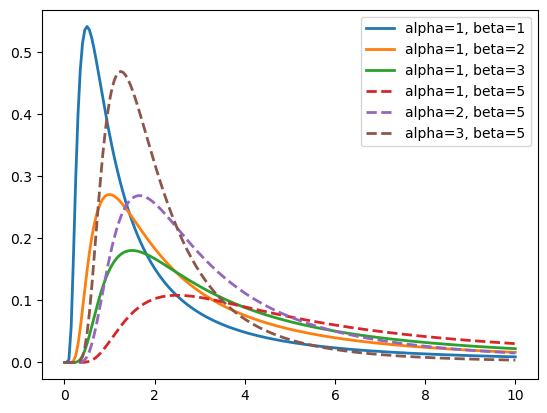

In [15]:
xx = np.linspace(0, 10, 200)

alpha = 1
for beta in [1, 2, 3]:
    logp = pm.logp(pm.InverseGamma.dist(alpha=alpha, beta=beta), xx)
    plt.plot(xx, np.exp(logp).eval(), label=f"alpha={alpha}, beta={beta}", lw=2)

beta = 5
for alpha in [1, 2, 3]:
    logp = pm.logp(pm.InverseGamma.dist(alpha=alpha, beta=beta), xx)
    plt.plot(xx, np.exp(logp).eval(), label=f"alpha={alpha}, beta={beta}", lw=2, linestyle="--")
    
plt.legend();

Now, let's rerun our model with an inverse gamma on the lengthscale prior.  We choose $\alpha=1$, $\beta=0.525$.  It's doing a few things here:
- It cuts out very small lengthscale values, but not too much.
- It has a long right tail that penalizes region 3b (but still allows it).
- Most of the mass is placed in region 2 and region 3a, in fact, I chose this particular priors hyperparamters so it's *median* occurs at about 0.75.  So we're saying that there's about a 50% chance that we're in region 1 and 2, and a 50% chance we're in region 3. 

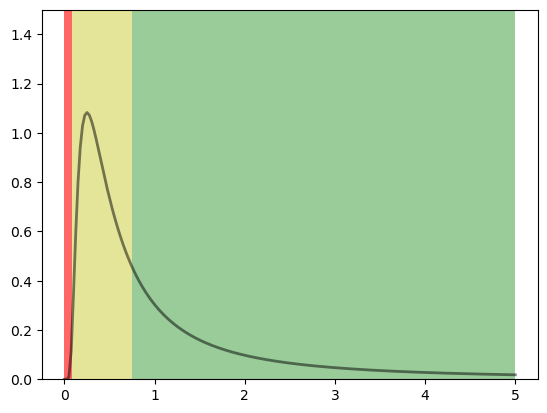

In [16]:
upper = 5
plt.fill_between([0, data_res], [25, 25], color="r", alpha=0.6, edgecolor=None, label="1. Small $\ell$");
plt.fill_between([data_res, 0.75], [25, 25], color="y", alpha=0.4, edgecolor=None, label="2. Medium $\ell$");
plt.fill_between([0.75, 5], [25, 25], color="green", alpha=0.4, edgecolor=None, label="3. Large $\ell$");
plt.ylim([0, 1.5]);

xx = np.linspace(0, 5, 200)
logp = pm.logp(pm.InverseGamma.dist(alpha=1, beta=0.5), xx)
plt.plot(xx, np.exp(logp).eval(), color="k", lw=2, alpha=0.5);

In [17]:
with pm.Model() as model:
    eta = pm.HalfNormal("eta", sigma=5)
    ell = pm.InverseGamma("ell", alpha=1, beta=0.525)
    
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    K = cov_func(x[:, None])
    
    L = pt.slinalg.cholesky(K + 1e-6 * pt.eye(N))
    v = pm.Normal("v", mu=0.0, sigma=1.0, size=N)
    f = pm.Deterministic("f", L @ v)
   
    beta0 = pm.Normal("beta0", mu=np.mean(y), sigma=5)
    mu = pm.Deterministic("mu", beta0 + f)
    
    sigma = pm.HalfNormal("sigma", sigma=5.0)
    y_ = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    idata = pm.sample(target_accept=0.95, nuts_sampler="numpyro")

/Users/andre/development/pymc/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.735837
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:17.212603
Transforming variables...
Transformation time =  0:00:00.160249


In [18]:
idata.sample_stats.diverging.sum()

<xarray.DataArray 'diverging' ()>
array(2)

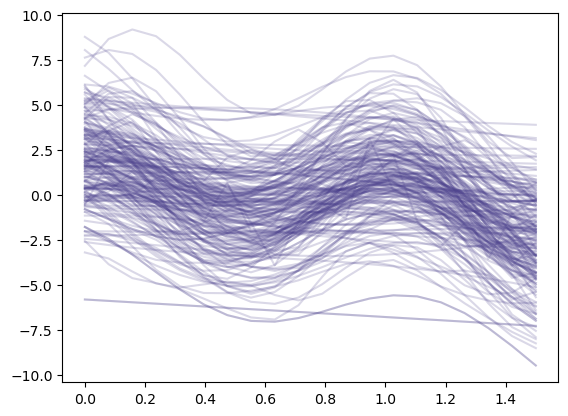

In [19]:
ix = np.random.randint(0, 4000, 200)
f_s = az.extract(idata.posterior, var_names="f").isel(sample=ix).data

plt.plot(x, f_s, color="darkslateblue", alpha=0.2);

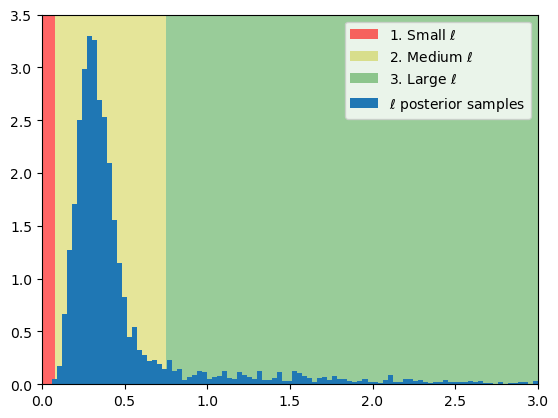

In [20]:
ell = az.extract(idata.posterior, var_names="ell")

plt.fill_between([0, data_res], [25, 25], color="r", alpha=0.6, edgecolor=None, label="1. Small $\ell$");
plt.fill_between([data_res, 0.75], [25, 25], color="y", alpha=0.4, edgecolor=None, label="2. Medium $\ell$");
plt.fill_between([0.75, 5], [25, 25], color="green", alpha=0.4, edgecolor=None, label="3. Large $\ell$");

plt.hist(ell.data, bins=np.linspace(0, 3, 100), density=True, label="$\ell$ posterior samples");
plt.xlim([0, 3]);
plt.ylim([0, 3.5]);

plt.legend();

This looks pretty reasonable.  There are much fewer samples in region one, and more of the samples have landed in a specific spot in region 2.  This strategy works well when we have good prior knowledge on our underlying function.  You should feel a little unsatisfied though.  It's fair to ask:

1. What if our goal is to determine whether or not this underlying function is present or if our data is all noise, and we don't actually know much or anything about the lengthscale?  Would this way of setting priors somehow bias our result?
2. We haven't really talked about the *scale* parameter $\eta$ much  It also controls "how much" of the GP is present, more obviously so than the lengthscale does.  Does $\eta$ and $\lengthscale$ interact?

*Yes* is the answer to both of those questions.  Maybe you're starting to see now that setting priors on GP hyperparameters is a pretty subtle situation.  Let's plot the posterior samples of $\ell$ and $\eta$ against each other in a scatterplot to confirm.

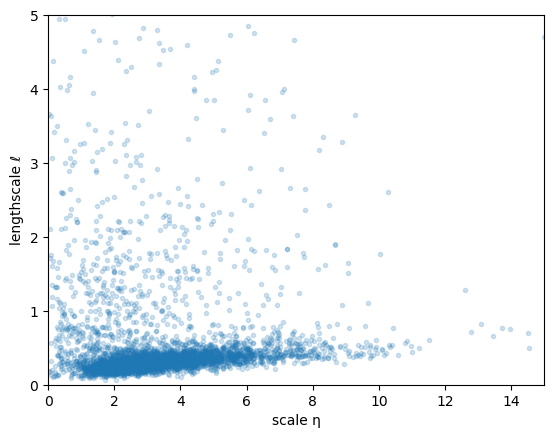

In [21]:
s1 = az.extract(idata.posterior, var_names="eta")
s2 = az.extract(idata.posterior, var_names="ell")
plt.scatter(s1, s2, marker='.', alpha=0.2)

plt.ylim([0, 5])
plt.xlim([0, 15]);
plt.xlabel("scale η")
plt.ylabel("lengthscale ℓ");

Sure enough there is a clear and pretty strong relationship between $\eta$ and $\ell$.  This means that we really should be thinking about both of these parameters jointly when we're setting priors on GP hyperparameters.  

## The Penalized Complexity (PC) prior

Penalized complexity priors are a framework for constructing priors where you think more in terms of model complexity than in terms of specific parameter values.  There are PC priors for GPs, hierarchical normal models, AR(p) models, splines, and many others.  Covering PC priors in detail is outside the scope of this course.  We're including the PC prior for GPs because it's very useful, straightforward to implement, and easy to operate.  It's a perfect choice for cases like the one above, where we're not sure a particular GP term is actually present in our data set -- and we want to be careful not to overfit a GP on to it.  Contrast this to the Mauna Loa CO2 data set we saw earlier in the course.  There's no ambiguity about whether a signal is present or not, it certainly is there.  In that situation, go with the inverse gamma or other informative prior approach because it gives you more control.  We'll circle back to that case study later when we've got more tools in our toolbox.

Think of two models, a base model and an expanded model.  The base model *doesn't* include the GP, and the expanded model does.  The expanded model is base model plus GP.  Additionally, the expanded model gets more complex as the lengthscale gets smaller, because smaller lengthscales produce more "wiggly" functions that use more degrees of freedom.  


The PC prior is defined such that it penalizes the *complexity* directly between the two models in an even way.  The prior on the measure of complexity is then transformed mathematically into priors on $\eta$ and $\ell$.  Nominally the PC prior is a joint prior on both $\eta$ and $\ell$, though in practice the priors separate nicely and have a very simple form that's easy to write in PyMC:

In [22]:
## PC prior on eta
alpha_scale, upper_scale = 0.1, 5.0
eta = pm.Exponential.dist(lam=-np.log(alpha_scale) / upper_scale)

## PC prior on ell
alpha_ell, lower_ell = 0.05, 4
lam_ell = -np.log(alpha_ell) * np.sqrt(lower_ell)
alpha = 0.5
beta = 1.0 / (lam_ell ** 2)
ell_inv = pm.Weibull.dist(alpha=alpha, beta=beta)
ell = 1 / ell_inv

The PC prior isn't *uninformative*.  As we've learned, trying to pick uninformative priors for GPs doesn't produce good results.  You need to pick 4 values:

1. $\alpha_\text{scale}$ and $U_{\text{scale}}$.  These numbers define how "big" you think the GP might be as a tail probability.  So for example, if you think a 10% chance that $\eta$ is bigger than 5, you'd set `alpha_scale = 0.1` and `upper_scale = 5`.
2. $\alpha_\text{lengthscale}$ and $L_{\text{lengthscale}}$.  Set a tail probability on the *smallest* lengthscale you'd expect to see.  This might be the resolution of your data points.  So, if you think that there is a 5% chance that the lengthscale is smaller than 4, you would set `alpha_ell = 0.05` and `lower_ell = 4`

Below these priors are plotted with the tail probabilities shaded.  Notice that there is a lot of shading for the lengthscale, even though its just 5% of the distribution.  This is because this is a *very* heavy tailed distribution.  The tails are even heavier than the inverse gamma. 

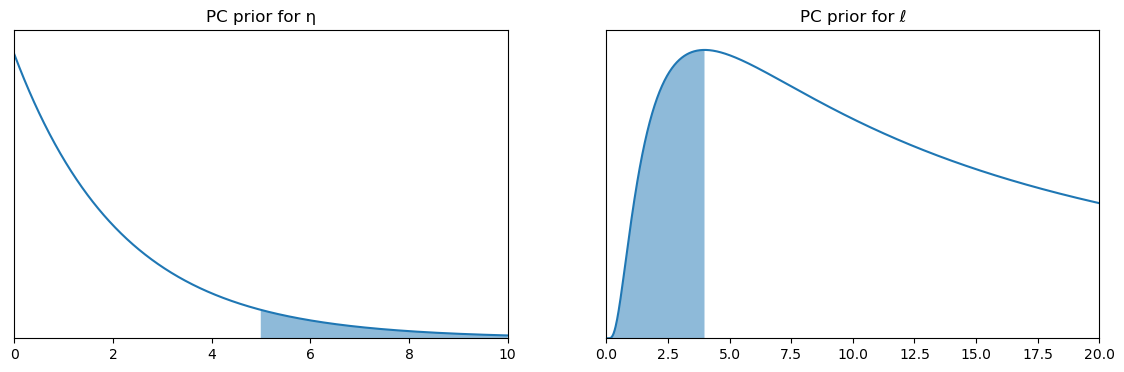

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4)); axs = axs.flatten();

xx = np.linspace(0, 10, 1000)
y_eta = np.exp(pm.logp(eta, xx).eval())
axs[0].plot(xx, y_eta)
ix = np.argmin(np.abs(xx - upper_scale))
axs[0].fill_between(xx[ix:], np.zeros(len(xx[ix:])), y_eta[ix:], alpha=0.5)
axs[0].set_xlim([0, 10])
axs[0].set_ylim([0, 0.5])
axs[0].set_yticks([])
axs[0].set_title("PC prior for η")

xx = np.linspace(0, 20, 1000)
y_ell = np.exp(pm.logp(ell, xx).eval())
axs[1].plot(xx, y_ell);
ix = np.argmin(np.abs(xx - lower_ell))
axs[1].fill_between(xx[:ix], np.zeros(len(xx[:ix])), y_ell[:ix], alpha=0.5)
axs[1].set_xlim([0, 20])
axs[1].set_ylim([0, 0.02]);
axs[1].set_yticks([])
axs[1].set_title("PC prior for ℓ");

Next, we fit the model with the PC prior.  I chose `upper_scale` and `alpha_scale` to line up as closely as possible to the prior we used on `eta` in the inverse gamma model so that the results are comparable.  For `HalfNormal(sigma=5)`, 32% of the mass is above 5.0.  The rest of the model is unchanged.  

In [38]:
with pm.Model() as model:
    ## PC prior on eta
    alpha_scale, upper_scale = 0.32, 5.0
    eta = pm.Exponential("eta", lam=-np.log(alpha_scale) / upper_scale)

    ## PC prior on ell
    alpha_ell, lower_ell = 0.001, data_res
    lam_ell = -np.log(alpha_ell) * np.sqrt(lower_ell)
    alpha = 0.5
    beta = 1.0 / (lam_ell ** 2)
    ell_inv = pm.Weibull("ell_inv", alpha=alpha, beta=beta)
    ell = pm.Deterministic("ell", 1 / ell_inv)
    
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    K = cov_func(x[:, None])
    
    L = pt.slinalg.cholesky(K + 1e-6 * pt.eye(N))
    v = pm.Normal("v", mu=0.0, sigma=1.0, size=N)
    f = pm.Deterministic("f", L @ v)
   
    beta0 = pm.Normal("beta0", mu=np.mean(y), sigma=5)
    mu = pm.Deterministic("mu", beta0 + f)
    
    sigma = pm.HalfNormal("sigma", sigma=5.0)
    y_ = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    idata_pc = pm.sample(target_accept=0.95, nuts_sampler="numpyro")

/Users/andre/development/pymc/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.570473
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:25.533793
Transforming variables...
Transformation time =  0:00:00.165879


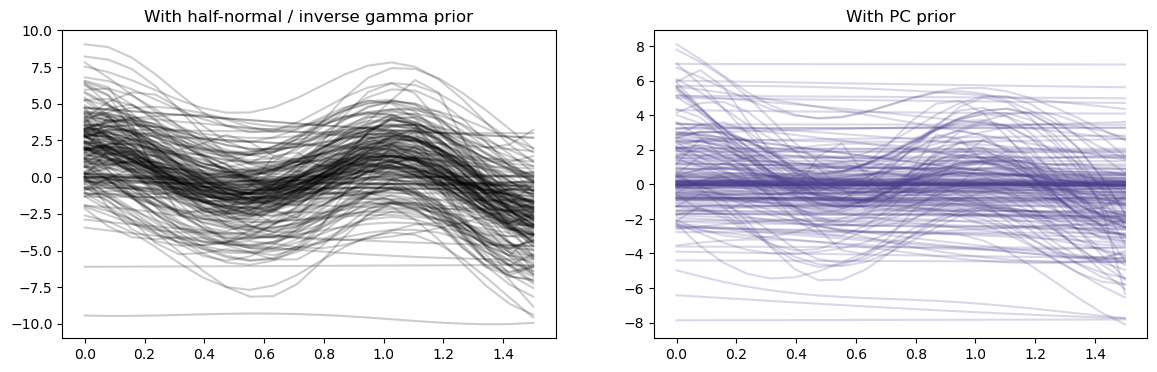

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4)); axs = axs.flatten();

ix = np.random.randint(0, 4000, 200)

f_s = az.extract(idata.posterior, var_names="f").isel(sample=ix).data
axs[0].plot(x, f_s, color="black", alpha=0.2);
axs[0].set_title("With half-normal / inverse gamma prior");

f_s = az.extract(idata_pc.posterior, var_names="f").isel(sample=ix).data
axs[1].plot(x, f_s, color="darkslateblue", alpha=0.2);
axs[1].set_title("With PC prior");

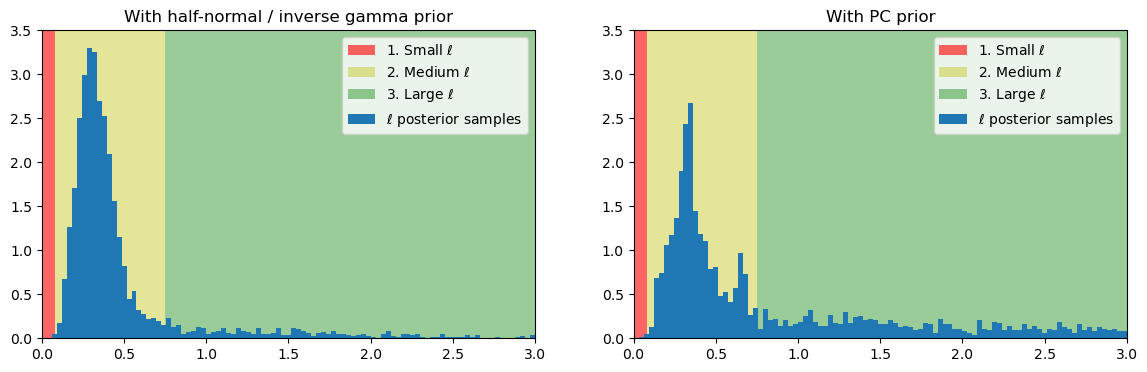

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4)); axs = axs.flatten();

ell = az.extract(idata.posterior, var_names="ell")

axs[0].fill_between([0, data_res], [25, 25], color="r", alpha=0.6, edgecolor=None, label="1. Small $\ell$");
axs[0].fill_between([data_res, 0.75], [25, 25], color="y", alpha=0.4, edgecolor=None, label="2. Medium $\ell$");
axs[0].fill_between([0.75, 5], [25, 25], color="green", alpha=0.4, edgecolor=None, label="3. Large $\ell$");
axs[0].hist(ell.data, bins=np.linspace(0, 3, 100), density=True, label="$\ell$ posterior samples");
axs[0].set_xlim([0, 3]);
axs[0].set_ylim([0, 3.5]);
axs[0].legend()
axs[0].set_title("With half-normal / inverse gamma prior");

ell = az.extract(idata_pc.posterior, var_names="ell")

axs[1].fill_between([0, data_res], [25, 25], color="r", alpha=0.6, edgecolor=None, label="1. Small $\ell$");
axs[1].fill_between([data_res, 0.75], [25, 25], color="y", alpha=0.4, edgecolor=None, label="2. Medium $\ell$");
axs[1].fill_between([0.75, 5], [25, 25], color="green", alpha=0.4, edgecolor=None, label="3. Large $\ell$");
axs[1].hist(ell.data, bins=np.linspace(0, 3, 100), density=True, label="$\ell$ posterior samples");
axs[1].set_xlim([0, 3]);
axs[1].set_ylim([0, 3.5]);
axs[1].legend();
axs[1].set_title("With PC prior");

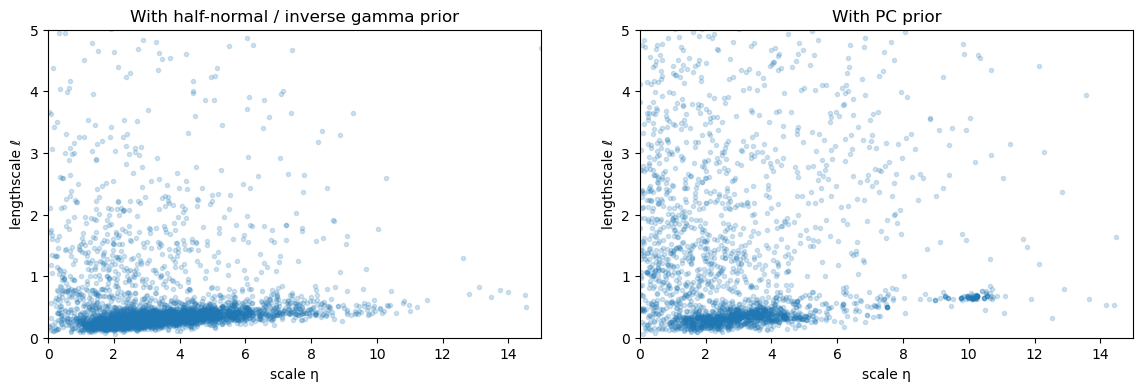

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4)); axs = axs.flatten();

s1 = az.extract(idata.posterior, var_names="eta")
s2 = az.extract(idata.posterior, var_names="ell")
axs[0].scatter(s1, s2, marker='.', alpha=0.2)
axs[0].set_ylim([0, 5])
axs[0].set_xlim([0, 15]);
axs[0].set_xlabel("scale η")
axs[0].set_ylabel("lengthscale ℓ");
axs[0].set_title("With half-normal / inverse gamma prior");

s1 = az.extract(idata_pc.posterior, var_names="eta")
s2 = az.extract(idata_pc.posterior, var_names="ell")
axs[1].scatter(s1, s2, marker='.', alpha=0.2)
axs[1].set_ylim([0, 5])
axs[1].set_xlim([0, 15]);
axs[1].set_xlabel("scale η")
axs[1].set_ylabel("lengthscale ℓ");
axs[1].set_title("With PC prior");

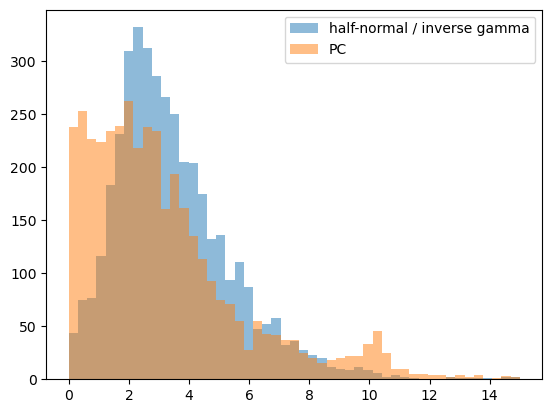

In [36]:
s1 = az.extract(idata, var_names="eta").data
s2 = az.extract(idata_pc, var_names="eta").data

bins = np.linspace(0, 15, 50)
plt.hist(s1, bins=bins, alpha=0.5, label="half-normal / inverse gamma")
plt.hist(s2, bins=bins, alpha=0.5, label="PC")
plt.legend();

The PC prior results are much different than the inverse gamma prior.  However, the results we get from the PC prior de-emphasize the GP.  Much of the posterior has moved over from region 2 to region 3.  Given that a-priori *we didn't know that the underlying function was there*, the half-normal / inverse gamma prior we were using was causing some *overfitting*.  However, *if we did know* that the underlying function was there, using the more specific inverse gamma prior helps the model recover it.  

In fact, now most of the lengthscale samples for the PC prior are now in region 3.  With the inverse gamma prior most of the samples are in region 2.  

In [37]:
res_pc = np.sum(az.extract(idata_pc, var_names="ell").data > 0.75)
res = np.sum(az.extract(idata, var_names="ell").data > 0.75)

print("PC prior, % of samples in region 3: ", res_pc / 4000)
print("Half-normal / inverse gamma, % of samples in region 3: ", res / 4000)

PC prior, % of samples in region 3:  0.65625
Half-normal / inverse gamma, % of samples in region 3:  0.1625


## Summary

Which prior you should use depends on which scenario you find yourself in.  If you don't know if there is an underlying function or not, use the PC prior.  It's designed for this case.  If you do know, you can still use the PC prior but it's better to be more informative about the lengthscale if you can.  The inverse gamma is a good distribution to use.  Also, I tend to use `pm.Exponential` priors for `eta` in most cases, not just with the PC prior.  It has a longer tail which allows for a stronger than expected effect from the GP.  The important point is to think carefully about your priors on `eta` and `ell` in the context of your data, they can have an outsized impact on the results of your analysis.  

Also, we didn't really demonstrate this, but GPs will give you a big heads up if your priors are terrible.  You'll have very slow sampling and lots of divergences.  Turning up `target_accept` won't get you too far.  We saw in the last section that even with the lengthscale fixed you can have a pretty complicated posterior geometry.  Now throw in changing `eta` and `ell` and you have the difficult geometry of the GP *compounded* by the changes in scale and lengthscale.  You'll observe this on the homework question where you use the `HalfFlat` prior for the lengthscale.  The ideas we've layed out for setting priors will help you get these issues under control.

In the next lesson we'll do two case studies, the first covering the scenario where we *know* that the underlying function is there, and one where we don't.  Another way to look at is is noise relative to signal.  In the first case study using the cherry blossom data, we the noise is small relative to the signal, and we want to model the function with a GP.  In the second case study, on a agricultural field, we don't know if there is an underlying GP.  

### HW problem

- Try increasing or decreasing the number of data points in the example, refitting the model, and looking at results.  Also try increasing or decreasing the noise level.  What changes, and why?

Watch for:
- reducing divergences with more data points
- increased divergences with few data points

Ans: For GPs, the number of data points absolutely effects the posterior geometry, thats the whole point!  It becomes harder to sample when the data is more ambiguous or noisy.  The lengthscale is more evenly split between region 1, 2, 3, and in each region the posterior geometry if the GP is way different (flat lines vs. sine-like waves vs. jaggy things). 

